In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

In [2]:
pd.set_option("display.max_columns", 50)

### Loading Kaggle IPL data

In [3]:
df = pd.read_csv("data/df_kaggleAllIpl_preprocessed.csv")
del df['Unnamed: 0']

#### Adding a is_wicket column

In [4]:
df["is_bowler_wicket"] = df["dismissal_kind"].isin(["caught","bowled","lbw","caught and bowled","stumped"]).values.astype(int)

In [5]:
df.head(2)

,match_id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,is_bowler_wicket
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0
1,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0


### Player statistics: Season and venue wise

In [6]:
### Number of runs scored
dfp = df.groupby(['season','venue','batting_team','batsman']).sum()["batsman_runs"].reset_index()
dfp = dfp.sort_values(['season', 'venue', 'batting_team','batsman_runs'], ascending=False)
dfp.rename(columns={"batsman":"player","batting_team":"team","batsman_runs":"runs_scored"}, inplace=True)

### Number of balls faced 
df1 = df.copy()
df1 = df1[df1['is_super_over']==0]
df1 = df1[df1['wide_runs']==0]
df1 = df1[df1['noball_runs']==0]
df1 = df1.groupby(['season','venue','batting_team','batsman']).count()["date"].reset_index()
df1.rename(columns={"date":"balls_faced","batting_team":"team","batsman":"player"}, inplace=True)
dfp = dfp.set_index(['season','venue','team','player']).join(df1.set_index(['season','venue','team','player'])).reset_index()

### Number of innings
df1 = df.copy()
df1 = df1.drop_duplicates(['match_id','batsman'])
df1 = df1.groupby(['season','venue','batting_team','batsman']).count()["date"].reset_index()
df1.rename(columns={"batting_team":"team","date":"num_innings","batsman":"player"}, inplace=True)
dfp = dfp.set_index(['season','venue','team','player']).join(df1.set_index(['season','venue','team','player'])).reset_index()

### Number of wickets
df1 = df.copy()
df1 = df1.groupby(['season','venue','bowling_team','bowler']).sum()["is_bowler_wicket"].reset_index()
df1.rename(columns={"is_bowler_wicket":"wickets","bowling_team":"team","bowler":"player"}, inplace=True)
df1 = df1.sort_values(['season','wickets'], ascending=False)
dfp = dfp.set_index(['season','venue','team','player']).join(df1.set_index(['season','venue','team','player']), how="outer").reset_index()

### Number of balls bowled 
df1 = df.copy()
df1 = df1[df1['is_super_over']==0]
df1 = df1[df1['wide_runs']==0]
df1 = df1[df1['noball_runs']==0]
df1 = df1.groupby(['season','venue','bowling_team','bowler']).count()["date"].reset_index()
df1.rename(columns={"date":"balls_bowled","bowling_team":"team","bowler":"player"}, inplace=True)
dfp = dfp.set_index(['season','venue','team','player']).join(df1.set_index(['season','venue','team','player'])).reset_index()

### Number of runs conceded
df1 = df.copy()
df1 = df1[df1['bye_runs']==0]
df1 = df1[df1['legbye_runs']==0]
df1 = df1.groupby(['season','venue','bowling_team','bowler']).sum()["total_runs"].reset_index()
df1.rename(columns={"total_runs":"runs_conceded","bowling_team":"team","bowler":"player"}, inplace=True)
dfp = dfp.set_index(['season','venue','team','player']).join(df1.set_index(['season','venue','team','player'])).reset_index()

### For players who did not bowl, wickets->0 balls_bowled->0 runs_conceded->0
dfp["wickets"].fillna(0, inplace=True)
dfp["balls_bowled"].fillna(0, inplace=True)
dfp["runs_conceded"].fillna(0, inplace=True)

### For players who did not bat, runs_scored->0, balls_faced->0
dfp["runs_scored"].fillna(0, inplace=True)
dfp["balls_faced"].fillna(0, inplace=True)
dfp["num_innings"].fillna(0, inplace=True)

dfp.head(5)

,season,venue,team,player,runs_scored,balls_faced,num_innings,wickets,balls_bowled,runs_conceded
0,2008,Dr DY Patil Sports Academy,Chennai Super Kings,CK Kapugedera,8.0,11.0,1.0,0.0,0.0,0.0
1,2008,Dr DY Patil Sports Academy,Chennai Super Kings,JA Morkel,16.0,13.0,1.0,2.0,24.0,25.0
2,2008,Dr DY Patil Sports Academy,Chennai Super Kings,L Balaji,0.0,0.0,0.0,0.0,24.0,42.0
3,2008,Dr DY Patil Sports Academy,Chennai Super Kings,M Muralitharan,0.0,0.0,0.0,2.0,24.0,39.0
4,2008,Dr DY Patil Sports Academy,Chennai Super Kings,M Ntini,0.0,0.0,0.0,0.0,24.0,21.0


### Verify the player statistics

In [7]:
aa = dfp.groupby(['season','team','player']).sum()["wickets"].reset_index()
aa = aa[aa["season"]==2016]
aa.sort_values("wickets", ascending=False).head(3)

,season,team,player,wickets
1527,2016,Sunrisers Hyderabad,B Kumar,23.0
1523,2016,Royal Challengers Bangalore,YS Chahal,21.0
1516,2016,Royal Challengers Bangalore,SR Watson,20.0


### Derived statistics
#### Batting: Average, strike-rate
#### Bowling:Average, strike-rate, economy rate

In [8]:
### Batting
dfp["bat_avg"] = dfp["runs_scored"]/dfp["num_innings"]
dfp["bat_sr"]  = dfp["runs_scored"]/dfp["balls_faced"]*100
dfp["bat_avgsr"]= dfp["bat_avg"]*dfp["bat_sr"]/100

### Bowling
dfp["bowl_avg"]= dfp["runs_conceded"]/dfp["wickets"]
dfp["bowl_sr"] = dfp["balls_bowled"]/dfp["wickets"]
dfp["bowl_econ"]=dfp["runs_conceded"]/dfp["balls_bowled"]*6
dfp.head(3)

,season,venue,team,player,runs_scored,balls_faced,num_innings,wickets,balls_bowled,runs_conceded,bat_avg,bat_sr,bat_avgsr,bowl_avg,bowl_sr,bowl_econ
0,2008,Dr DY Patil Sports Academy,Chennai Super Kings,CK Kapugedera,8.0,11.0,1.0,0.0,0.0,0.0,8.0,72.727273,5.818182,NaN,NaN,NaN
1,2008,Dr DY Patil Sports Academy,Chennai Super Kings,JA Morkel,16.0,13.0,1.0,2.0,24.0,25.0,16.0,123.076923,19.692308,12.500000,12.000000,6.25
2,2008,Dr DY Patil Sports Academy,Chennai Super Kings,L Balaji,0.0,0.0,0.0,0.0,24.0,42.0,NaN,NaN,NaN,inf,inf,10.50


In [12]:
dfp[(dfp["season"]==2016) & (dfp["player"]=="JW Hastings")]

,season,venue,team,player,runs_scored,balls_faced,num_innings,wickets,balls_bowled,runs_conceded,bat_avg,bat_sr,bat_avgsr,bowl_avg,bowl_sr,bowl_econ
6910,2016,Eden Gardens,Kolkata Knight Riders,JW Hastings,0.0,0.0,0.0,2.0,40.0,37.0,NaN,NaN,NaN,18.5,20.0,5.55


### Per season venue wise statistics: to make player statistics venue and season (=>pitch) neutral

In [202]:
### Median bat_avg * bat_sr for each venue during different seasons
dfv = dfp.copy()
dfv = dfv[dfv["runs_scored"]>=20]
dfv = dfv.groupby(["season","venue"]).median()[["bat_avg","bat_sr","bat_avgsr"]].reset_index()
dfv.rename(columns={"bat_avg":"sv_bat_avg","bat_sr":"sv_bat_sr", "bat_avgsr":"sv_bat_avgsr"}, inplace=True)

### Standard deviation: batting average, batting strike rate
df1 = dfp.copy()
df1 = df1[df1["runs_scored"]>=20]
df1 = df1.groupby(["season","venue"]).std()[["bat_avg","bat_sr"]].reset_index()
df1.rename(columns={"bat_avg":"sv_std_bat_avg","bat_sr":"sv_std_bat_sr"}, inplace=True)

dfv = dfv.set_index(["season","venue"]).join(df1.set_index(["season","venue"])).reset_index()

### Median bowling average, bowling economy for each venue
df1 = dfp.copy()
df1 = df1[np.isfinite(df1["bowl_avg"])]
df1 = df1[np.isfinite(df1["bowl_sr"])]
df1 = df1[np.isfinite(df1["bowl_econ"])]
df1 = df1[df1["balls_bowled"]>=12]
df1 = df1.groupby(["season","venue"]).median()[["bowl_avg","bowl_econ"]].reset_index()

dfv = dfv.set_index(["season","venue"]).join(df1.set_index(["season","venue"])).reset_index()
dfv.rename(columns={"bowl_avg":"sv_bowl_avg", "bowl_econ":"sv_bowl_econ","bowl_avgecon":"sv_bowl_avgecon"}, inplace=True)

### Standard deviation: bowling average, bowling economy for each venue
df1 = dfp.copy()
df1 = df1[np.isfinite(df1["bowl_avg"])]
df1 = df1[np.isfinite(df1["bowl_sr"])]
df1 = df1[np.isfinite(df1["bowl_econ"])]
df1 = df1[df1["balls_bowled"]>=12]
df1 = df1.groupby(["season","venue"]).std()[["bowl_avg","bowl_econ"]].reset_index()
df1.rename(columns={"bowl_avg":"sv_std_bowl_avg","bowl_econ":"sv_std_bowl_econ"}, inplace=True)

dfv = dfv.set_index(["season","venue"]).join(df1.set_index(["season","venue"])).reset_index()
dfv.head(3)

,season,venue,sv_bat_avg,sv_bat_sr,sv_bat_avgsr,sv_std_bat_avg,sv_std_bat_sr,sv_bowl_avg,sv_bowl_econ,sv_std_bowl_avg,sv_std_bowl_econ
0,2008,Dr DY Patil Sports Academy,29.0,137.777778,40.080357,20.252371,33.292177,18.333333,7.500000,13.588289,1.844588
1,2008,Eden Gardens,26.0,121.127503,29.250919,15.291004,42.184812,19.333333,7.000000,14.297174,2.158578
2,2008,Feroz Shah Kotla,30.5,160.622711,56.227508,13.556141,44.202442,22.750000,8.433333,27.485175,1.594114


### Merge player and venue statistics

In [203]:
dfpv = dfp.set_index(["season","venue"]).join(dfv.set_index(["season","venue"])).reset_index()
dfpv = dfpv[["season","venue","team","player","runs_scored","bat_avg","bat_sr","bat_avgsr",
             "sv_bat_avg","sv_bat_sr","sv_bat_avgsr","sv_std_bat_avg","sv_std_bat_sr", "wickets",
             "balls_bowled","bowl_avg","bowl_sr","bowl_econ","sv_bowl_avg","sv_bowl_econ",
             "sv_std_bowl_avg","sv_std_bowl_econ"]]
dfpv.head(3)

,season,venue,team,player,runs_scored,bat_avg,bat_sr,bat_avgsr,sv_bat_avg,sv_bat_sr,sv_bat_avgsr,sv_std_bat_avg,sv_std_bat_sr,wickets,balls_bowled,bowl_avg,bowl_sr,bowl_econ,sv_bowl_avg,sv_bowl_econ,sv_std_bowl_avg,sv_std_bowl_econ
0,2008,Dr DY Patil Sports Academy,Chennai Super Kings,CK Kapugedera,8.0,8.0,72.727273,5.818182,29.0,137.777778,40.080357,20.252371,33.292177,0.0,0.0,NaN,NaN,NaN,18.333333,7.5,13.588289,1.844588
1,2008,Dr DY Patil Sports Academy,Chennai Super Kings,JA Morkel,16.0,16.0,123.076923,19.692308,29.0,137.777778,40.080357,20.252371,33.292177,2.0,24.0,12.500000,12.000000,6.25,18.333333,7.5,13.588289,1.844588
2,2008,Dr DY Patil Sports Academy,Chennai Super Kings,L Balaji,0.0,NaN,NaN,NaN,29.0,137.777778,40.080357,20.252371,33.292177,0.0,24.0,inf,inf,10.50,18.333333,7.5,13.588289,1.844588


### Batting metrics:
For each season
    1. WPA
    2. sum_over_venue ( bat_avg * bat_sr - (bat_avg_venueSeason * bat_sr_venueSeason) )
                                   or
       sum_over_venue ( (bat_avg - bat_avg_venueSeason) * (bat_sr - bat_sr_venueSeason) )
    3. (?) Total runs, average, strike rate

### Batting metric 2

In [251]:
dfbat = dfpv.copy()

dfbat = dfbat[dfbat["runs_scored"]>=20]
dfbat.loc[dfbat["runs_scored"]==0,"bat_avg"] = dfbat.loc[dfbat["runs_scored"]==0,"sv_bat_avg"]
dfbat.loc[dfbat["runs_scored"]==0,"bat_sr"]  = dfbat.loc[dfbat["runs_scored"]==0,"sv_bat_sr"]

dfbat["zs_bat_avg"] = (dfbat["bat_avg"]-dfbat["sv_bat_avg"])/dfbat["sv_std_bat_avg"]
dfbat["zs_bat_sr"]  = (dfbat["bat_sr"]-dfbat["sv_bat_sr"])/dfbat["sv_std_bat_sr"]
dfbat = dfbat.groupby(["season","team","player"]).sum()[["runs_scored","zs_bat_avg","zs_bat_sr"]].reset_index()

### Weights
wr = 2; wa=2; ws=1
dfbat["bat_venue"] = wr*dfbat["runs_scored"] + wa*dfbat["zs_bat_avg"]  +  ws*dfbat["zs_bat_sr"]

In [260]:
aa = dfbat[(dfbat["season"]==2016)]
aa.sort_values("bat_venue", ascending=False).head(5)

,season,team,player,runs_scored,zs_bat_avg,zs_bat_sr,bat_venue
789,2016,Royal Challengers Bangalore,V Kohli,959.0,9.505328,-2.055872,1934.954784
794,2016,Sunrisers Hyderabad,DA Warner,830.0,9.881143,2.636200,1682.398485
779,2016,Royal Challengers Bangalore,AB de Villiers,681.0,6.221226,4.303240,1378.745691
766,2016,Mumbai Indians,RG Sharma,484.0,7.784743,-0.226711,983.342774
751,2016,Kolkata Knight Riders,G Gambhir,482.0,5.043471,-3.284137,970.802805


### Bowling metrics:

    1. WPA
    2. sum_over_venue ( bowl_avg * bowl_econ - (bowl_avg_venueSeason * bowl_econ_venueSeason) )
                                   or
       sum_over_venue( (bowl_avg - bowl_avg_venueSeason) * (bowl_econ - bowl_econ_venueSeason) )       
    3. Wickets weighted by batsman's metric.

### Bowling metric 2

In [248]:
dfball=dfpv.copy()

dfball.loc[dfball["wickets"]==0,"bowl_avg"] = dfball.loc[dfball["wickets"]==0,"sv_bowl_avg"]
dfball = dfball[dfball["balls_bowled"]>=12]

dfball["zs_bowl_avg"] = (dfball["sv_bowl_avg"]-dfball["bowl_avg"])/dfball["sv_std_bowl_avg"]
dfball["zs_bowl_econ"] =(dfball["sv_bowl_econ"]-dfball["bowl_econ"])/dfball["sv_std_bowl_econ"]
dfball = dfball.groupby(["season","team","player"]).sum()[["wickets","zs_bowl_avg","zs_bowl_econ"]].reset_index()

### Weights
ww = 1; wa=1; we=1
dfball["bowl_venue"] = ww*dfball["wickets"] + wa*dfball["zs_bowl_avg"]  +  we*dfball["zs_bowl_econ"]

In [249]:
aa = dfball[dfball["season"]==2017]
aa.sort_values("bowl_venue", ascending=False).head(10)

,season,team,player,wickets,zs_bowl_avg,zs_bowl_econ,bowl_venue
1052,2017,Sunrisers Hyderabad,B Kumar,25.0,3.489338,3.347801,31.837139
1031,2017,Rising Pune Supergiant,JD Unadkat,24.0,2.746745,2.246299,28.993044
1043,2017,Royal Challengers Bangalore,P Negi,16.0,4.310550,6.743162,27.053712
1061,2017,Sunrisers Hyderabad,Rashid Khan,17.0,1.751950,7.311974,26.063925
1017,2017,Mumbai Indians,JJ Bumrah,19.0,0.380129,1.313020,20.693149
1019,2017,Mumbai Indians,KV Sharma,13.0,2.114729,3.584798,18.699527
1009,2017,Kolkata Knight Riders,NM Coulter-Nile,15.0,2.276914,0.393055,17.669970
974,2017,Gujarat Lions,AJ Tye,12.0,1.868739,2.176041,16.044780
1021,2017,Mumbai Indians,MJ McClenaghan,19.0,0.149879,-3.153220,15.996659
971,2017,Delhi Daredevils,PJ Cummins,15.0,-0.046908,0.254268,15.207360


## Ideal team

In [262]:
dfps = dfp.groupby(["season","team","player"]).sum()[["runs_scored","balls_faced","num_innings",
                                                      "wickets","balls_bowled","runs_conceded"]].reset_index()
dfps["bat_avg"] = dfps["runs_scored"]/dfps["num_innings"]
dfps["bat_sr"]  = dfps["runs_scored"]/dfps["balls_faced"] * 100

dfps["bowl_avg"]= dfps["runs_conceded"]/dfps["wickets"]
dfps["bowl_sr"] = dfps["balls_bowled"]/dfps["wickets"]
dfps["bowl_econ"]=dfps["runs_conceded"]/dfps["balls_bowled"]*6

df1 = dfbat.copy()
del df1["runs_scored"]
dfps = dfps.set_index(["season","team","player"]).join(df1.set_index(["season","team","player"])).reset_index()

df1 = dfball.copy()
del df1["wickets"]
dfps = dfps.set_index(["season","team","player"]).join(df1.set_index(["season","team","player"])).reset_index()

### Batting Weights
wr = 2; wa=2; ws=1
dfps["bat_venue"] = wr*dfps["runs_scored"] + wa*dfps["zs_bat_avg"]  +  ws*dfps["zs_bat_sr"]

### Bowling Weights
ww = 1; wa=1; we=1
dfps["bowl_venue"] = ww*dfps["wickets"] + wa*dfps["zs_bowl_avg"]  +  we*dfps["zs_bowl_econ"]

dfps

,season,team,player,runs_scored,balls_faced,num_innings,wickets,balls_bowled,runs_conceded,bat_avg,bat_sr,bowl_avg,bowl_sr,bowl_econ,zs_bat_avg,zs_bat_sr,bat_venue,zs_bowl_avg,zs_bowl_econ,bowl_venue
0,2008,Chennai Super Kings,A Mukund,0.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008,Chennai Super Kings,CK Kapugedera,16.0,22.0,3.0,0.0,17.0,49.0,5.333333,72.727273,inf,inf,17.294118,NaN,NaN,NaN,NaN,NaN,NaN
2,2008,Chennai Super Kings,JA Morkel,241.0,162.0,10.0,17.0,288.0,399.0,24.100000,148.765432,23.470588,16.941176,8.312500,0.947986,0.832292,484.728265,-0.797214,-1.687492,14.515295
3,2008,Chennai Super Kings,JDP Oram,18.0,12.0,2.0,3.0,96.0,149.0,9.000000,150.000000,49.666667,32.000000,9.312500,NaN,NaN,NaN,-0.463609,-1.334473,1.201917
4,2008,Chennai Super Kings,Joginder Sharma,16.0,11.0,2.0,8.0,148.0,239.0,8.000000,145.454545,29.875000,18.500000,9.689189,NaN,NaN,NaN,-2.983529,-2.745397,2.271074
5,2008,Chennai Super Kings,L Balaji,0.0,4.0,1.0,11.0,198.0,286.0,0.000000,0.000000,26.000000,18.000000,8.666667,NaN,NaN,NaN,-0.235056,-2.661739,8.103204
6,2008,Chennai Super Kings,M Muralitharan,0.0,3.0,1.0,11.0,348.0,404.0,0.000000,0.000000,36.727273,31.636364,6.965517,NaN,NaN,NaN,-2.670280,2.930149,11.259870
7,2008,Chennai Super Kings,M Ntini,11.0,18.0,2.0,7.0,210.0,242.0,5.500000,61.111111,34.571429,30.000000,6.914286,NaN,NaN,NaN,1.203756,4.958726,13.162482
8,2008,Chennai Super Kings,MEK Hussey,168.0,100.0,3.0,0.0,0.0,0.0,56.000000,168.000000,NaN,NaN,NaN,4.705563,1.519892,346.931018,NaN,NaN,NaN
9,2008,Chennai Super Kings,ML Hayden,189.0,127.0,4.0,0.0,0.0,0.0,47.250000,148.818898,NaN,NaN,NaN,2.295548,0.366805,382.957902,NaN,NaN,NaN


### Team metric

In [266]:
dft = dfps.groupby(["season","team"]).sum()[["bat_venue","bowl_venue"]].reset_index()
dft

,season,team,bat_venue,bowl_venue
0,2008,Chennai Super Kings,4634.670263,65.731840
1,2008,Deccan Chargers,4119.876907,37.372871
2,2008,Delhi Daredevils,3899.142564,60.451347
3,2008,Kings XI Punjab,4654.304334,49.592535
4,2008,Kolkata Knight Riders,3567.404909,47.991414
5,2008,Mumbai Indians,3556.278573,76.477524
6,2008,Rajasthan Royals,4720.768272,73.860638
7,2008,Royal Challengers Bangalore,3604.973200,35.167179
8,2009,Chennai Super Kings,4041.431603,70.880356
9,2009,Deccan Chargers,4460.091245,64.252180


In [270]:
dft[dft['season']==2017]

,season,team,bat_venue,bowl_venue
76,2017,Delhi Daredevils,4193.724543,48.763787
77,2017,Gujarat Lions,4554.511438,5.887623
78,2017,Kings XI Punjab,3937.193085,50.922591
79,2017,Kolkata Knight Riders,4659.066882,61.756547
80,2017,Mumbai Indians,5120.536960,100.892979
81,2017,Rising Pune Supergiant,4617.769312,98.512265
82,2017,Royal Challengers Bangalore,3256.992338,45.449703
83,2017,Sunrisers Hyderabad,4510.163829,69.595214


In [349]:
dft["team"].unique()

array(['Chennai Super Kings', 'Deccan Chargers', 'Delhi Daredevils',
       'Kings XI Punjab', 'Kolkata Knight Riders', 'Mumbai Indians',
       'Rajasthan Royals', 'Royal Challengers Bangalore',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Gujarat Lions', 'Rising Pune Supergiants', 'Rising Pune Supergiant'], dtype=object)

In [351]:
winners_list = {"2008":"Rajasthan Royals",
                "2009":"Deccan Chargers",
                "2010":"Chennai Super Kings",
                "2011":"Chennai Super Kings",
                "2012":"Kolkata Knight Riders",
                "2013":"Mumbai Indians",
                "2014":"Kolkata Knight Riders",
                "2015":"Mumbai Indians",
                "2016":"Sunrisers Hyderabad",
                "2017":"Mumbai Indians"}
dfwin = pd.DataFrame.from_dict(winners_list, orient='index')
dfwin=dfwin.reset_index()
dfwin.columns = ["season","team"]
dfwin

losers_list =  {"2008":"Deccan Chargers",
                "2009":"Kolkata Knight Riders",
                "2010":"Kings XI Punjab",
                "2011":"Delhi Daredevils",
                "2012":"Pune Warriors",
                "2013":"Delhi Daredevils",
                "2014":"Delhi Daredevils",
                "2015":"Kings XI Punjab",
                "2016":"Kings XI Punjab",
                "2017":"Royal Challengers Bangalore"}
dflos = pd.DataFrame.from_dict(losers_list, orient='index')
dflos=dflos.reset_index()
dflos.columns = ["season","team"]
dflos

,season,team
0,2008,Deccan Chargers
1,2009,Kolkata Knight Riders
2,2010,Kings XI Punjab
3,2011,Delhi Daredevils
4,2012,Pune Warriors
5,2013,Delhi Daredevils
6,2014,Delhi Daredevils
7,2015,Kings XI Punjab
8,2016,Kings XI Punjab
9,2017,Royal Challengers Bangalore


### Player types

In [298]:
dft = dfps[ (dfps["season"]==2017) & (dfps["team"]=="Sunrisers Hyderabad") ]
del dft["balls_faced"], dft["num_innings"], dft["balls_bowled"], dft["runs_conceded"]
dft

,season,team,player,runs_scored,wickets,bat_avg,bat_sr,bowl_avg,bowl_sr,bowl_econ,zs_bat_avg,zs_bat_sr,bat_venue,zs_bowl_avg,zs_bowl_econ,bowl_venue
1683,2017,Sunrisers Hyderabad,A Nehra,0.0,8.0,NaN,NaN,24.625000,15.875000,9.307087,NaN,NaN,NaN,-2.059478,-3.348050,2.592472
1684,2017,Sunrisers Hyderabad,B Kumar,4.0,26.0,2.000000,100.000000,14.192308,12.076923,7.050955,NaN,NaN,NaN,3.489338,3.347801,32.837139
1685,2017,Sunrisers Hyderabad,BB Sran,0.0,0.0,NaN,NaN,inf,inf,14.500000,NaN,NaN,NaN,0.000000,-3.875817,-3.875817
1686,2017,Sunrisers Hyderabad,BCJ Cutting,51.0,1.0,17.000000,196.153846,123.000000,76.000000,9.710526,-0.644455,1.989099,102.700189,-1.539976,-2.686092,-3.226068
1687,2017,Sunrisers Hyderabad,Bipul Sharma,31.0,3.0,10.333333,129.166667,43.000000,32.666667,7.897959,-0.239672,0.000000,61.520656,-1.092287,-0.924477,0.983236
1688,2017,Sunrisers Hyderabad,CJ Jordan,0.0,1.0,0.000000,0.000000,9.000000,6.000000,9.000000,NaN,NaN,NaN,NaN,NaN,NaN
1689,2017,Sunrisers Hyderabad,DA Warner,641.0,0.0,45.785714,142.761693,NaN,NaN,NaN,5.539248,-1.103959,1291.974536,NaN,NaN,NaN
1690,2017,Sunrisers Hyderabad,DJ Hooda,78.0,2.0,13.000000,150.000000,21.000000,12.000000,10.500000,-1.270311,0.199980,153.659357,0.539765,-0.461313,2.078453
1691,2017,Sunrisers Hyderabad,KS Williamson,256.0,0.0,36.571429,152.380952,NaN,NaN,NaN,0.695299,1.229586,514.620184,NaN,NaN,NaN
1692,2017,Sunrisers Hyderabad,MC Henriques,277.0,1.0,25.181818,136.453202,248.000000,144.000000,10.333333,0.746717,0.321398,555.814831,-4.449849,-8.610966,-12.060814


### Types of batsmen: Average vs Strike-rate

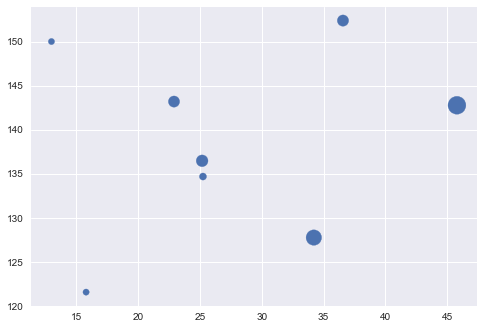

In [299]:
aa = dft.copy()
aa = aa[aa["runs_scored"]>=70]
plt.scatter(aa["bat_avg"], aa["bat_sr"], s=aa["runs_scored"]/2)

### Types of bowler: Average vs Economy

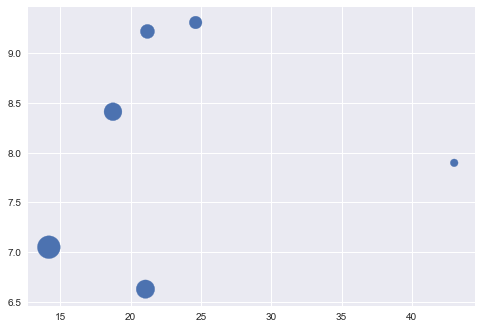

In [300]:
aa = dft.copy()
aa = aa[aa['wickets']>=3]
plt.scatter(aa["bowl_avg"], aa["bowl_econ"],s=aa["wickets"]*20)

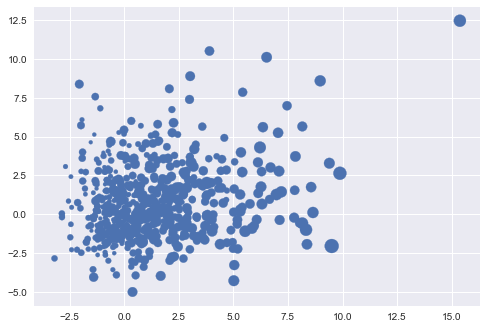

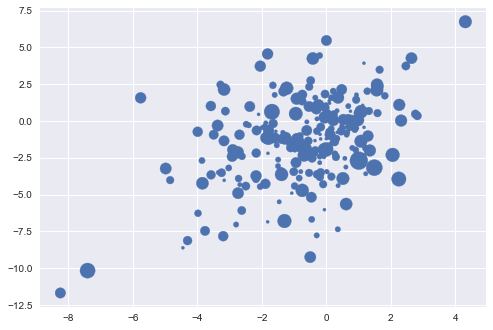

In [315]:
aa = dfps.copy()
#aa = aa[aa['season']==2017]
aa = aa[aa['runs_scored']>=70]
plt.figure()
plt.scatter(aa["zs_bat_avg"],aa["zs_bat_sr"], s=aa["runs_scored"]/5)
plt.figure()
plt.scatter(aa["zs_bowl_avg"],aa["zs_bowl_econ"], s=aa["wickets"]*10)

### Type of batsmen: Dot balls vs Balls per boundary

In [339]:
int(dfwin.iloc[0]["season"])

2008

In [ ]:
dft[dft["season"]]

### Winning teams vs losing teams

In [352]:
dft = dfps.copy()
dfw = pd.DataFrame()
dfl = pd.DataFrame()

for i in range(len(dfwin)):
    df1 = dft[(dft['season']==int(dfwin.iloc[i]["season"])) & (dft['team']==dfwin.iloc[i]["team"])]
    dfw = dfw.append(df1)

for i in range(len(dflos)):
    df1 = dft[(dft['season']==int(dflos.iloc[i]["season"])) & (dft['team']==dflos.iloc[i]["team"])]
    dfl = dfl.append(df1)

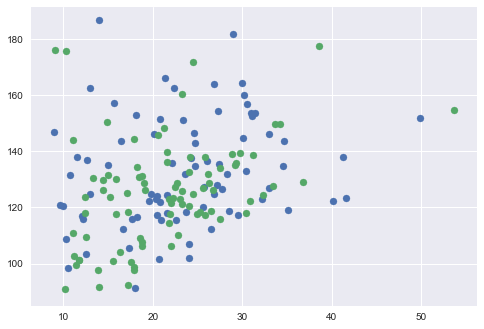

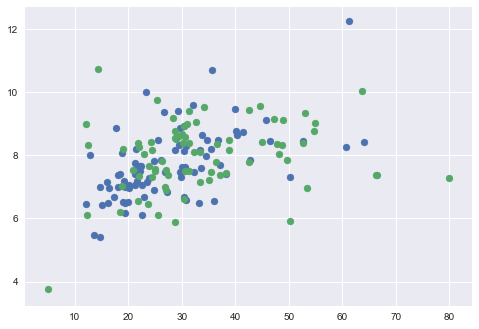

In [353]:
plt.figure()
aa = dfw.copy()
aa = aa[aa['runs_scored']>=70]
plt.scatter(aa["bat_avg"], aa["bat_sr"])
aa = dfl.copy()
aa = aa[aa['runs_scored']>=70]
plt.scatter(aa["bat_avg"], aa["bat_sr"])

plt.figure()
aa = dfw.copy()
aa = aa[aa['wickets']>=3]
plt.scatter(aa["bowl_avg"], aa["bowl_econ"])
aa = dfl.copy()
aa = aa[aa['wickets']>=3]
plt.scatter(aa["bowl_avg"], aa["bowl_econ"])